In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
# Read CSV Data
df = pd.read_csv("Yield Curve.csv", parse_dates=["Date"])

# Sort CSV Data
df = df.sort_values(by="Date")

# Melt the DataFrame so each row is [Date, Maturity, Yield].
melted = df.melt(id_vars="Date", var_name="Maturity", value_name="Yield")

C:\Users\npwol\AppData\Local\Temp\ipykernel_29668\2756767653.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("Yield Curve.csv", parse_dates=["Date"])


c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


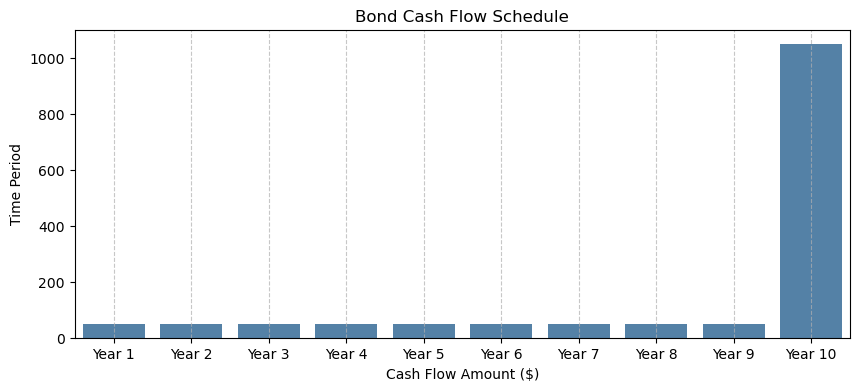

In [82]:
# Assumptions for Bond Pricing


# Bond parameters
face_value = 1000           # Bond face value
coupon_rate = 0.05          # Annual coupon rate (5%)
market_rate = 0.04          # Market discount rate (4%)
periods = 10                # Number of periods (years)


#-------------------------------------------------------------------


# Calculate cash flows per period.
coupon_payment = face_value * coupon_rate
cash_flows = [coupon_payment] * (periods - 1) + [coupon_payment + face_value]

# Create an array of period labels.
time_periods = np.arange(1, periods + 1)
period_labels = [f"Year {t}" for t in time_periods]


#-------------------------------------------------------------------


# Create a horizontal bar chart.
plt.figure(figsize=(10, 4))  # Correct way to specify figure size.
sns.barplot(x = period_labels, y = cash_flows, color = "steelblue")
plt.xlabel("Cash Flow Amount ($)")
plt.ylabel("Time Period")
plt.title("Bond Cash Flow Schedule")
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.show()


# Bond Risk Measures

- **(Macaulay) Duration**  
  Duration measures the weighted average time to receive cash flows and is an indicator of interest rate sensitivity.

- **Modified Duration**  
  Modified Duration adjusts Macaulay Duration for the current interest rate, offering a more direct measure of price sensitivity.

- **Convexity**  
  Convexity measures the curvature in the bond’s price–yield relationship, improving the accuracy of estimated price changes when yield shifts are large.


c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


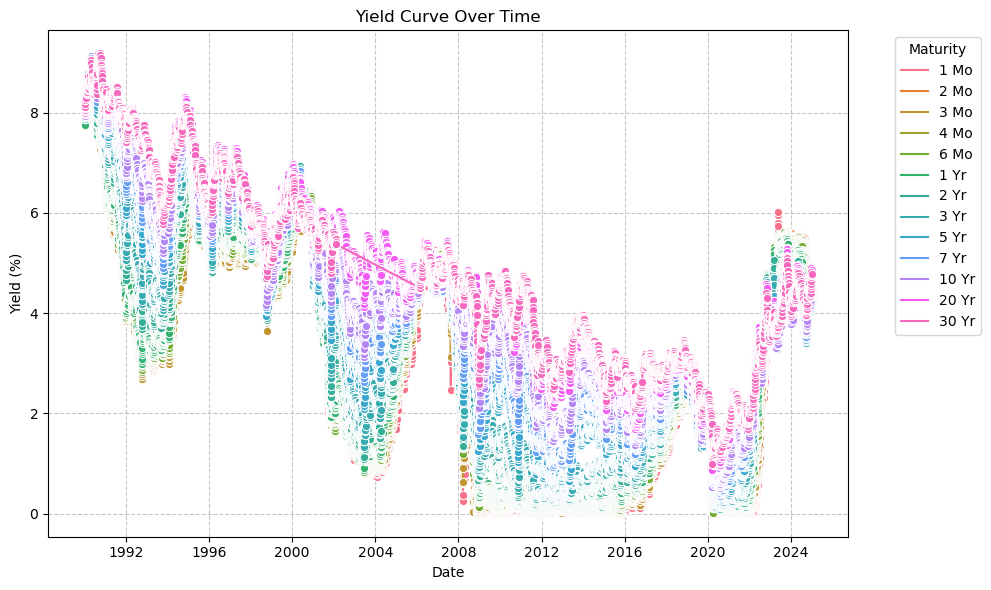

In [83]:
# 3. Plot the yields for each maturity over time.
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted, x="Date", y="Yield", hue="Maturity", marker="o")
plt.title("Yield Curve Over Time")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(title="Maturity", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


C:\Users\npwol\AppData\Local\Temp\ipykernel_29668\3948413852.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_yield_curve["Macaulay Duration"] = macaulay_durations
C:\Users\npwol\AppData\Local\Temp\ipykernel_29668\3948413852.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_yield_curve["Modified Duration"] = modified_durations
C:\Users\npwol\AppData\Local\Temp\ipykernel_29668\3948413852.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

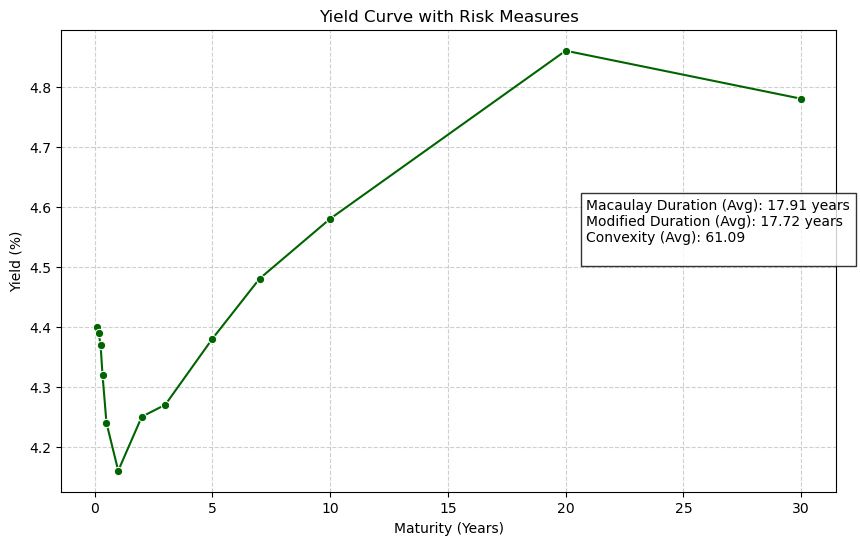

In [92]:
# -----------------------------
# 📝 Step 2: Convert Maturity Labels into Numerical Values (Years)
# -----------------------------

def convert_maturity(maturity):
    """
    Converts maturity strings (e.g., '3 Mo', '5 Yr') into numerical values in years.
    - "Mo" (Months) is divided by 12 to get years.
    - "Yr" (Years) remains the same.
    """
    if "Mo" in maturity:
        return int(maturity.split(" ")[0]) / 12  # Convert months to years
    elif "Yr" in maturity:
        return int(maturity.split(" ")[0])  # Convert years directly
    return None  # Return None for unexpected values

# Apply conversion function to create a new column with numerical maturities
melted["Maturity (Years)"] = melted["Maturity"].apply(convert_maturity)

# -----------------------------
# 📝 Step 3: Extract the Latest Yield Curve for Analysis
# -----------------------------

# Identify the most recent date in the dataset
latest_date = df["Date"].max()

# Filter the data to include only the latest available yield curve
latest_yield_curve = melted[melted["Date"] == latest_date]

# -----------------------------
# 📝 Step 4: Define Discount Rate (Risk-Free Rate)
# -----------------------------

# Use the 3-month yield as the risk-free discount rate
# Convert it from percentage to decimal
discount_rate_row = latest_yield_curve[latest_yield_curve["Maturity"] == "3 Mo"]
if not discount_rate_row.empty:
    discount_rate = discount_rate_row["Yield"].values[0] / 100  # Convert from percentage to decimal
else:
    discount_rate = 0.04  # Default fallback if 3-Mo rate is missing

# -----------------------------
# 📝 Step 5: Compute Bond Risk Measures (Macaulay Duration, Modified Duration, Convexity)
# -----------------------------

def compute_risk_measures(yield_rate, maturity, compounding=4):
    """
    Computes key bond risk measures:
    - Macaulay Duration (time-weighted present value of cash flows)
    - Modified Duration (sensitivity of bond price to yield changes)
    - Convexity (curvature of price-yield relationship)

    Parameters:
    - yield_rate: Coupon rate of the bond (as a percentage)
    - maturity: Bond maturity in years
    - compounding: Number of compounding periods per year (e.g., 4 for quarterly)

    Returns:
    - Macaulay Duration, Modified Duration, Convexity
    """

    # Bond assumptions
    face_value = 1000  # Bond face value ($1000)
    coupon_rate = yield_rate / 100  # Convert percentage to decimal
    periods = max(1, int(maturity * compounding))  # Ensure at least 1 period
    coupon_payment = (coupon_rate * face_value) / compounding  # Periodic coupon payment

    # Compute discount factors for present value calculations
    discount_factors = [(1 + discount_rate / compounding) ** (-t) for t in range(1, periods + 1)]
    
    if len(discount_factors) == 0:
        return 0, 0, 0  # Prevent errors for extremely short maturities

    # Present value of cash flows (Coupons + Final Face Value)
    pv_cashflows = [coupon_payment * df for df in discount_factors]
    pv_cashflows.append(face_value * discount_factors[-1])  # Add final face value payment
    
    # Compute Macaulay Duration (Time-weighted present value of cash flows)
    macaulay_duration = sum([(t + 1) * pv for t, pv in enumerate(pv_cashflows)]) / sum(pv_cashflows)
    
    # Compute Modified Duration (Sensitivity to yield changes)
    modified_duration = macaulay_duration / (1 + discount_rate / compounding)
    
    # Compute Convexity (Second derivative of price-yield relationship)
    convexity = sum([(t + 1) * (t + 2) * pv for t, pv in enumerate(pv_cashflows)]) / (sum(pv_cashflows) * (compounding ** 2))
    
    return macaulay_duration, modified_duration, convexity

# -----------------------------
# 📝 Step 6: Compute Risk Measures for Each Bond Maturity
# -----------------------------

# Initialize lists to store results
macaulay_durations, modified_durations, convexities = [], [], []

# Iterate through each bond maturity and calculate risk measures
for _, row in latest_yield_curve.iterrows():
    maturity = row["Maturity (Years)"]
    yield_rate = row["Yield"]
    
    if not np.isnan(maturity):  # Ensure valid data
        mac_dur, mod_dur, conv = compute_risk_measures(yield_rate, maturity)
        macaulay_durations.append(mac_dur)
        modified_durations.append(mod_dur)
        convexities.append(conv)
    else:
        macaulay_durations.append(None)
        modified_durations.append(None)
        convexities.append(None)

# Store calculated risk measures in the DataFrame
latest_yield_curve["Macaulay Duration"] = macaulay_durations
latest_yield_curve["Modified Duration"] = modified_durations
latest_yield_curve["Convexity"] = convexities

# -----------------------------
# 📝 Step 7: Plot the Yield Curve with Risk Measure Annotations
# -----------------------------

# Create the Yield Curve plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=latest_yield_curve, x="Maturity (Years)", y="Yield", marker="o", color="darkgreen")
plt.title("Yield Curve with Risk Measures")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.grid(True, linestyle="--", alpha=0.6)

# Compute average values for annotation
avg_macaulay = np.nanmean(macaulay_durations)
avg_modified = np.nanmean(modified_durations)
avg_convexity = np.nanmean(convexities)

# Add text annotation with key risk measures
textstr = (
    f"Macaulay Duration (Avg): {avg_macaulay:.2f} years\n"
    f"Modified Duration (Avg): {avg_modified:.2f} years\n"
    f"Convexity (Avg): {avg_convexity:.2f}\n"
)

plt.gcf().text(0.65, 0.5, textstr, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Show the final plot
plt.show()


c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


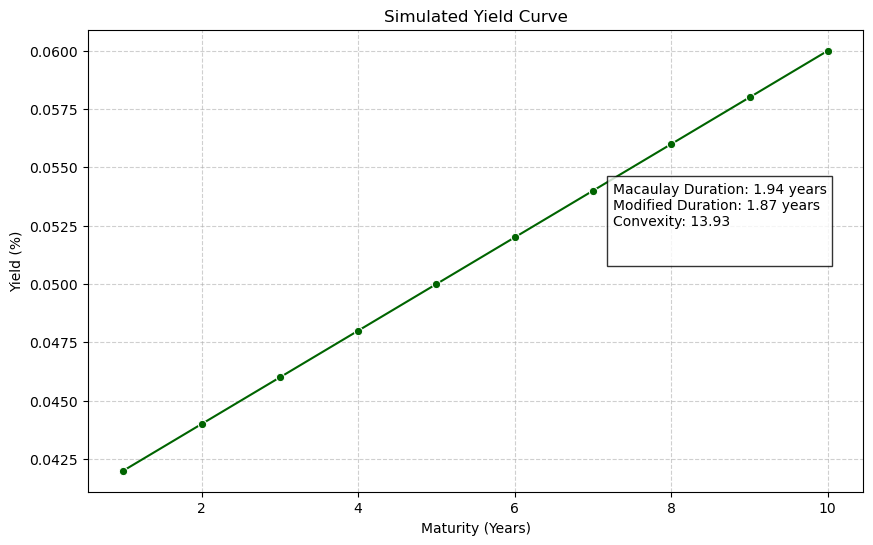

In [ ]:
# Assumptions for Risk Measures

macaulay_duration_value =    # in years
modified_duration_value =    # in years
convexity_value =            # dimensionless









# Simulate a simple yield curve for demonstration purposes.
# (In practice, yield curves are obtained from market data.)
years = np.arange(1, periods + 1)
# For demonstration, let’s assume yields increase gradually with maturity.
yields = market_rate + 0.002 * years  # a small upward slope

plt.figure(figsize=(10, 6))
sns.lineplot(x=years, y=yields, marker="o", color="darkgreen")
plt.title("Simulated Yield Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.grid(True, linestyle="--", alpha=0.6)

# Annotate the plot with duration and convexity info
textstr = (
    f"Macaulay Duration: {macaulay_duration_value} years\n"
    f"Modified Duration: {modified_duration_value} years\n"
    f"Convexity: {convexity_value}\n\n"
    )

plt.gcf().text(0.65, 0.5, textstr, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.show()


    "This heatmap represents the binomial tree for pricing a bond with an embedded option.\n"
    "Each cell shows the bond’s value at that node after accounting for coupon payments\n"
    "and discounting back using the risk-free rate. For a callable bond, the issuer can\n"
    "redeem the bond at par (face value) if the expected future value exceeds it.\n"
    "This process is done via backward induction from maturity to the present."

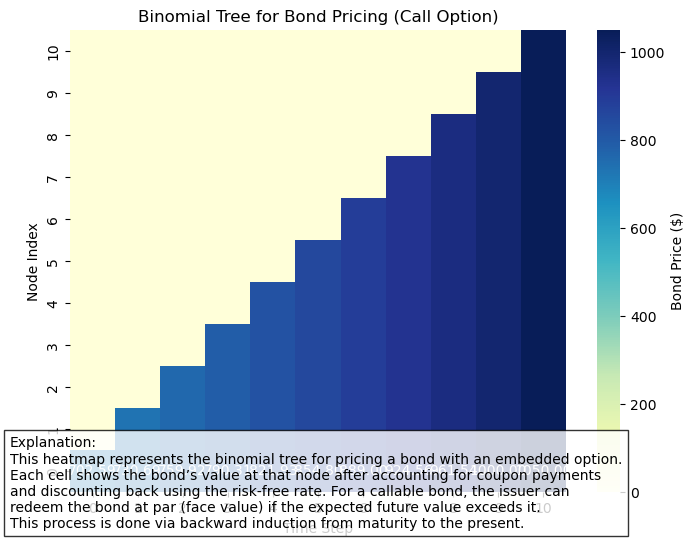

In [85]:
# Binomial tree parameters for option embedded bond pricing
up_factor = 1.1             # Up factor in the tree
down_factor = 0.9           # Down factor in the tree
risk_free_rate = 0.04       # Risk-free rate for discounting in the binomial model
option_type = "call"        # Option type: choose from None, 'call', or 'put'



# Define a helper function to compute the full binomial tree.
def binomial_tree_bond_tree(face_value, coupon_rate, up_factor, down_factor, risk_free_rate, periods, option_type=None):
    bond_tree = np.zeros((periods + 1, periods + 1))
    # Terminal nodes: at maturity, bond pays face value plus coupon.
    for i in range(periods + 1):
        bond_tree[i, periods] = face_value + (face_value * coupon_rate)
    # Backward induction
    for j in range(periods - 1, -1, -1):
        for i in range(j + 1):
            expected_value = 0.5 * (
                bond_tree[i, j + 1] / (1 + risk_free_rate) +
                bond_tree[i + 1, j + 1] / (1 + risk_free_rate)
            )
            # Option adjustments: for a callable bond, the issuer may redeem the bond if it is advantageous.
            if option_type == 'call':
                bond_tree[i, j] = min(face_value, expected_value)
            elif option_type == 'put':
                bond_tree[i, j] = max(face_value, expected_value)
            else:
                bond_tree[i, j] = expected_value
    return bond_tree

# Compute the full binomial tree for visualization.
bond_tree_matrix = binomial_tree_bond_tree(face_value, coupon_rate, up_factor, down_factor, risk_free_rate, periods, option_type)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(bond_tree_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Bond Price ($)'})
plt.title(f"Binomial Tree for Bond Pricing ({option_type.capitalize()} Option)")
plt.xlabel("Time Step")
plt.ylabel("Node Index")
plt.gca().invert_yaxis()  # Invert y-axis so that the root is at the top

plt.gcf().text(0.05, 0.05, explanation, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.show()


In [86]:
def price_bond(face_value, coupon_rate, market_rate, periods):

    cash_flows = np.array([(face_value * coupon_rate) / (1 + market_rate) ** t for t in range(1, periods + 1)])
    final_value = face_value / (1 + market_rate) ** periods  # Discounted face value
    return np.sum(cash_flows) + final_value

# Example Parameters
face_value = 1000  # Bond face value
coupon_rate = 0.05  # 5% annual coupon
market_rate = 0.04  # Market discount rate of 4%
periods = 10  # 10 years to maturity

# Compute Bond Price
bond_price = price_bond(face_value, coupon_rate, market_rate, periods)
print(f"Traditional Bond Price: ${bond_price:.2f}")


Traditional Bond Price: $1081.11


In [87]:
# ==============================
# SECTION 3: DURATION & CONVEXITY CALCULATION
# ==============================

def calculate_duration(face_value, coupon_rate, market_rate, periods):
    
    cash_flows = np.array([(face_value * coupon_rate) / (1 + market_rate) ** t for t in range(1, periods + 1)])
    weighted_times = np.array([t * cf for t, cf in enumerate(cash_flows, 1)])
    bond_price = np.sum(cash_flows) + face_value / (1 + market_rate) ** periods

    macaulay_duration = np.sum(weighted_times) / bond_price
    modified_duration = macaulay_duration / (1 + market_rate)

    return macaulay_duration, modified_duration

def calculate_convexity(face_value, coupon_rate, market_rate, periods):

    cash_flows = np.array([(face_value * coupon_rate) / (1 + market_rate) ** t for t in range(1, periods + 1)])
    weighted_times = np.array([(t * (t + 1) * cf) for t, cf in enumerate(cash_flows, 1)])
    bond_price = np.sum(cash_flows) + face_value / (1 + market_rate) ** periods

    convexity = np.sum(weighted_times) / (bond_price * (1 + market_rate) ** 2)
    return convexity

# Compute Duration & Convexity
macaulay_duration, modified_duration = calculate_duration(face_value, coupon_rate, market_rate, periods)
convexity = calculate_convexity(face_value, coupon_rate, market_rate, periods)

print(f"Macaulay Duration: {macaulay_duration:.2f} years")
print(f"Modified Duration: {modified_duration:.2f} years")
print(f"Convexity: {convexity:.2f}")


Macaulay Duration: 1.94 years
Modified Duration: 1.87 years
Convexity: 13.93


In [88]:
def binomial_tree_bond(face_value, coupon_rate, up_factor, down_factor, risk_free_rate, periods, option_type=None):

    # Initialize tree with terminal bond values
    bond_tree = np.zeros((periods + 1, periods + 1))

    # Calculate future bond values at maturity
    for i in range(periods + 1):
        bond_tree[i, periods] = face_value + (face_value * coupon_rate)

    # Work backward through tree
    for j in range(periods - 1, -1, -1):
        for i in range(j + 1):
            expected_value = 0.5 * (bond_tree[i, j + 1] / (1 + risk_free_rate) + bond_tree[i + 1, j + 1] / (1 + risk_free_rate))

            if option_type == 'call':
                bond_tree[i, j] = min(face_value, expected_value)  # Callable bond logic
            elif option_type == 'put':
                bond_tree[i, j] = max(face_value, expected_value)  # Putable bond logic
            else:
                bond_tree[i, j] = expected_value  # Normal bond pricing

    return bond_tree[0, 0]  # Return root node value

# Example Parameters
up_factor = 1.1
down_factor = 0.9
risk_free_rate = 0.04
option_type = "call"  # Can be None, 'call', or 'put'

# Compute Bond Prices
binomial_bond_price = binomial_tree_bond(face_value, coupon_rate, up_factor, down_factor, risk_free_rate, periods, option_type)
print(f"Bond Price (Binomial Tree - {option_type} option): ${binomial_bond_price:.2f}")


Bond Price (Binomial Tree - call option): $702.59


Traditional Bond Price: $1081.11
Macaulay Duration: 1.94 years
Modified Duration: 1.87 years
Convexity: 13.93
Bond Price (Binomial Tree - call option): $702.59


c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


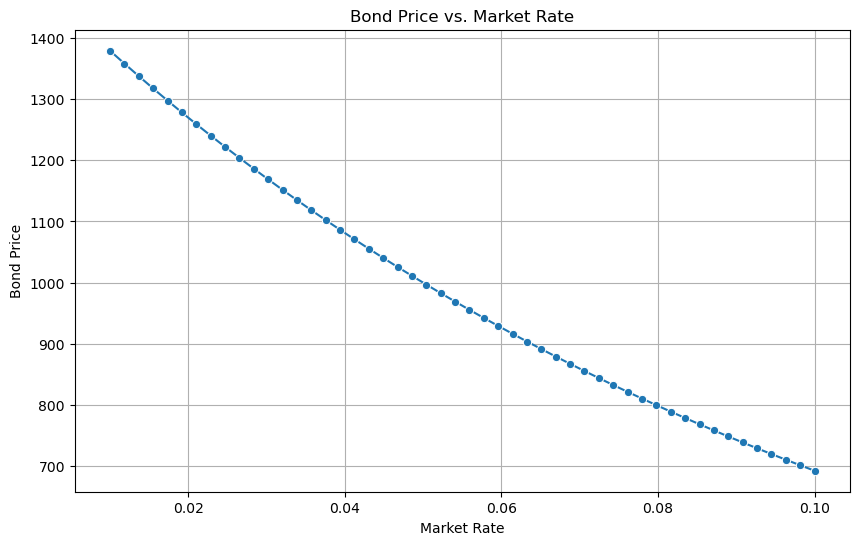

c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\npwol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

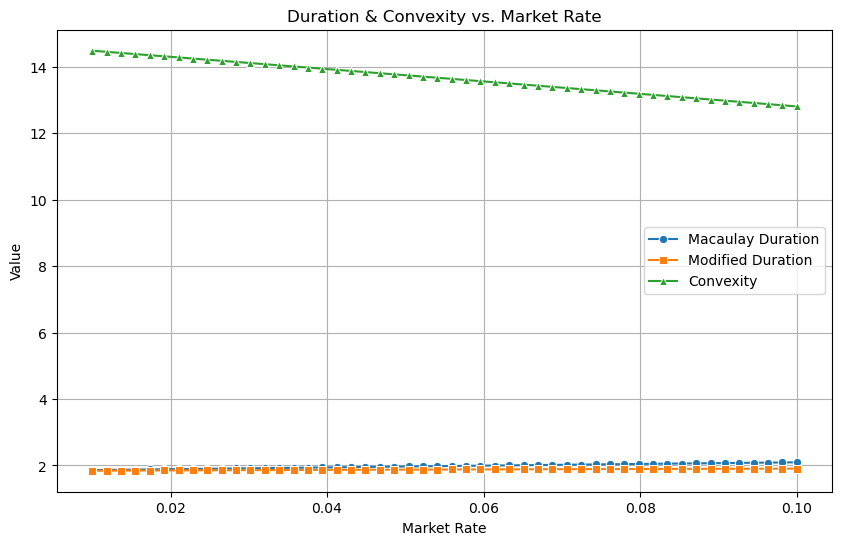

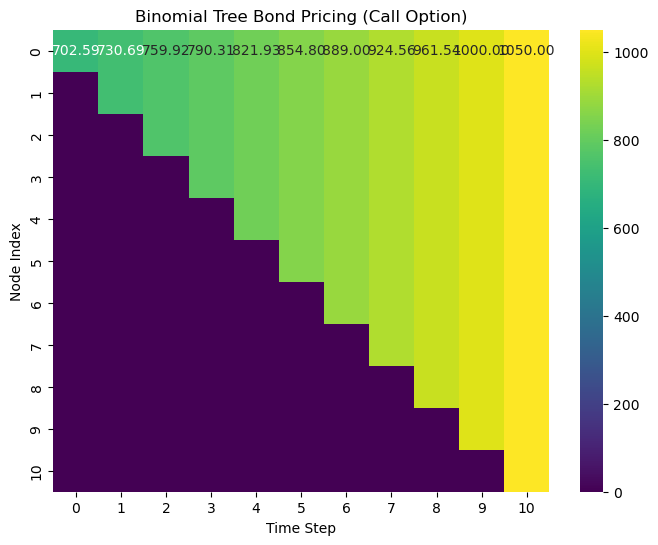

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# SECTION 1: TRADITIONAL BOND PRICING
# ------------------------------

def price_bond(face_value, coupon_rate, market_rate, periods):
    cash_flows = np.array([
        (face_value * coupon_rate) / (1 + market_rate) ** t 
        for t in range(1, periods + 1)
    ])
    final_value = face_value / (1 + market_rate) ** periods  # Discounted face value
    return np.sum(cash_flows) + final_value

# ------------------------------
# SECTION 2: DURATION & CONVEXITY CALCULATION
# ------------------------------

def calculate_duration(face_value, coupon_rate, market_rate, periods):
    cash_flows = np.array([
        (face_value * coupon_rate) / (1 + market_rate) ** t 
        for t in range(1, periods + 1)
    ])
    weighted_times = np.array([t * cf for t, cf in enumerate(cash_flows, 1)])
    bond_price = np.sum(cash_flows) + face_value / (1 + market_rate) ** periods

    macaulay_duration = np.sum(weighted_times) / bond_price
    modified_duration = macaulay_duration / (1 + market_rate)

    return macaulay_duration, modified_duration

def calculate_convexity(face_value, coupon_rate, market_rate, periods):
    cash_flows = np.array([
        (face_value * coupon_rate) / (1 + market_rate) ** t 
        for t in range(1, periods + 1)
    ])
    weighted_times = np.array([
        t * (t + 1) * cf for t, cf in enumerate(cash_flows, 1)
    ])
    bond_price = np.sum(cash_flows) + face_value / (1 + market_rate) ** periods
    convexity = np.sum(weighted_times) / (bond_price * (1 + market_rate) ** 2)
    return convexity

# ------------------------------
# SECTION 3: BINOMIAL TREE BOND PRICING
# ------------------------------

def binomial_tree_bond(face_value, coupon_rate, up_factor, down_factor, risk_free_rate, periods, option_type=None):
    # Initialize tree with terminal bond values
    bond_tree = np.zeros((periods + 1, periods + 1))
    # Terminal nodes: at maturity, bond pays face value plus coupon
    for i in range(periods + 1):
        bond_tree[i, periods] = face_value + (face_value * coupon_rate)
    # Backward induction
    for j in range(periods - 1, -1, -1):
        for i in range(j + 1):
            expected_value = 0.5 * (
                bond_tree[i, j + 1] / (1 + risk_free_rate) + 
                bond_tree[i + 1, j + 1] / (1 + risk_free_rate)
            )
            if option_type == 'call':
                bond_tree[i, j] = min(face_value, expected_value)  # Callable bond logic
            elif option_type == 'put':
                bond_tree[i, j] = max(face_value, expected_value)  # Putable bond logic
            else:
                bond_tree[i, j] = expected_value  # Normal bond pricing
    return bond_tree[0, 0]  # Return the root node value

# Helper function to return the full binomial tree (for visualization)
def binomial_tree_bond_tree(face_value, coupon_rate, up_factor, down_factor, risk_free_rate, periods, option_type=None):
    bond_tree = np.zeros((periods + 1, periods + 1))
    for i in range(periods + 1):
        bond_tree[i, periods] = face_value + (face_value * coupon_rate)
    for j in range(periods - 1, -1, -1):
        for i in range(j + 1):
            expected_value = 0.5 * (
                bond_tree[i, j + 1] / (1 + risk_free_rate) + 
                bond_tree[i + 1, j + 1] / (1 + risk_free_rate)
            )
            if option_type == 'call':
                bond_tree[i, j] = min(face_value, expected_value)
            elif option_type == 'put':
                bond_tree[i, j] = max(face_value, expected_value)
            else:
                bond_tree[i, j] = expected_value
    return bond_tree

# ------------------------------
# Example Parameters
# ------------------------------

face_value = 1000      # Bond face value
coupon_rate = 0.05     # 5% annual coupon
market_rate = 0.04     # Market discount rate of 4%
periods = 10           # 10 years to maturity
up_factor = 1.1        # Up factor for binomial model
down_factor = 0.9      # Down factor for binomial model
risk_free_rate = 0.04  # Risk-free rate for discounting in the binomial model
option_type = "call"   # Option type can be None, 'call', or 'put'

# Compute and print traditional bond price
bond_price = price_bond(face_value, coupon_rate, market_rate, periods)
print(f"Traditional Bond Price: ${bond_price:.2f}")

# Compute and print duration and convexity
macaulay_duration, modified_duration = calculate_duration(face_value, coupon_rate, market_rate, periods)
convexity = calculate_convexity(face_value, coupon_rate, market_rate, periods)
print(f"Macaulay Duration: {macaulay_duration:.2f} years")
print(f"Modified Duration: {modified_duration:.2f} years")
print(f"Convexity: {convexity:.2f}")

# Compute and print binomial tree bond price
binomial_bond_price = binomial_tree_bond(face_value, coupon_rate, up_factor, down_factor, risk_free_rate, periods, option_type)
print(f"Bond Price (Binomial Tree - {option_type} option): ${binomial_bond_price:.2f}")

# ------------------------------
# Visualization Section
# ------------------------------

# 1. Bond Price vs. Market Rate
market_rates = np.linspace(0.01, 0.1, 50)  # Vary market rate from 1% to 10%
bond_prices = [price_bond(face_value, coupon_rate, mr, periods) for mr in market_rates]

plt.figure(figsize=(10, 6))
sns.lineplot(x=market_rates, y=bond_prices, marker="o")
plt.title('Bond Price vs. Market Rate')
plt.xlabel('Market Rate')
plt.ylabel('Bond Price')
plt.grid(True)
plt.show()

# 2. Duration & Convexity vs. Market Rate
durations = []
mod_durations = []
convexities = []

for mr in market_rates:
    mac_duration, mod_duration = calculate_duration(face_value, coupon_rate, mr, periods)
    durations.append(mac_duration)
    mod_durations.append(mod_duration)
    convexities.append(calculate_convexity(face_value, coupon_rate, mr, periods))

plt.figure(figsize=(10, 6))
sns.lineplot(x=market_rates, y=durations, marker="o", label="Macaulay Duration")
sns.lineplot(x=market_rates, y=mod_durations, marker="s", label="Modified Duration")
sns.lineplot(x=market_rates, y=convexities, marker="^", label="Convexity")
plt.title('Duration & Convexity vs. Market Rate')
plt.xlabel('Market Rate')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 3. Binomial Tree Heatmap
# Generate the full binomial tree matrix for visualization.
bond_tree_matrix = binomial_tree_bond_tree(face_value, coupon_rate, up_factor, down_factor, risk_free_rate, periods, option_type)

plt.figure(figsize=(8, 6))
sns.heatmap(bond_tree_matrix, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title(f'Binomial Tree Bond Pricing ({option_type.capitalize()} Option)')
plt.xlabel('Time Step')
plt.ylabel('Node Index')
plt.show()
